In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F

from glob import glob
from tqdm import tqdm

# Read Data

In [2]:
path = './data/'
train_npy_path = sorted(glob(path+'train/*.npy'))

In [3]:
train_csv = pd.read_csv(path+'train.csv')
train_csv.head()

,month,file_nm
0,1978-11,197811.npy
1,1978-12,197812.npy
2,1979-01,197901.npy
3,1979-02,197902.npy
4,1979-03,197903.npy


In [4]:
train = []
for p in tqdm(train_npy_path):
    train.append(np.load(p))
train = np.array(train)

100%|███████████████████████████████████████████████████████████████████████████████| 482/482 [00:04<00:00, 109.54it/s]


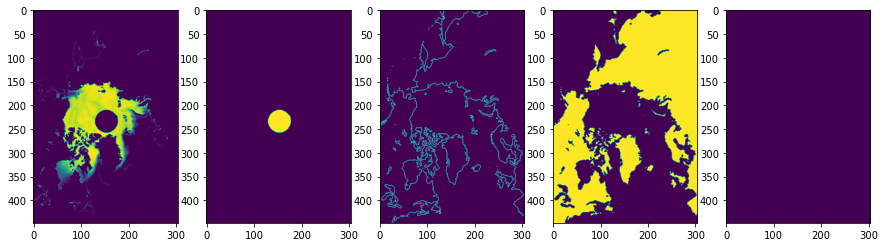

In [5]:
plt.figure(figsize=(15,10))
plt.subplot(151)
plt.imshow(train[0,:,:,0])
plt.subplot(152)
plt.imshow(train[0,:,:,1])
plt.subplot(153)
plt.imshow(train[0,:,:,2])
plt.subplot(154)
plt.imshow(train[0,:,:,3])
plt.subplot(155)
plt.imshow(train[0,:,:,4])

### about data
#### train : 훈련용 npy 데이터 (1978년~2018년 월별 482개 데이터)

* 각 파일(*.npy)은 해빙 농도(0~250), 북극점(위성 관측 불가 영역), 해안선 마스크, 육지 마스크, 결측값 5개의 채널로 구성
==>북극점, 해안선 마스크, 육지 마스크 데이터는 불변??? 결국 신경써야하는 데이터는 해빙농도 뿐?

## check whether other features matters

In [6]:
def check_all_same(channel):
    c_train = train[:, :, :, channel]
    same = True
    for image in c_train:
        same = same and not(np.bitwise_xor(image,c_train[0]).any())
    return same

In [7]:
for i in range(5):
    print("channel {} : {}".format(i, check_all_same(i)))

channel 0 : False
channel 1 : False
channel 2 : True
channel 3 : True
channel 4 : True


## Only channel 0, 1 Effects the data
As expected the coastal mask, and map maks, and missing data does not effect the data.
So we will going to change the data to 2 channel image, and start preprocessing

## How I will view the Data
The data here is time series image, but I will not use RNN or LSTM. Instead I will treat the year and month as seperate factor and use NN. Because the temperature is periodic to the season of the year, and the average temperature would change as year. But before assuming this, Let's check out whether this theory is right

In [8]:
train_df = pd.DataFrame()

In [9]:
# train_df['year'] = pd.DatetimeIndex(train_csv['month']).year
train_df['concentration'] = np.mean(train[:,:,:,0].reshape(482, -1), axis = 1)
train_df['pole'] = np.mean(train[:,:,:,1].reshape(482, -1), axis = 1)
train_df.index = pd.DatetimeIndex(train_csv['month'])


[]

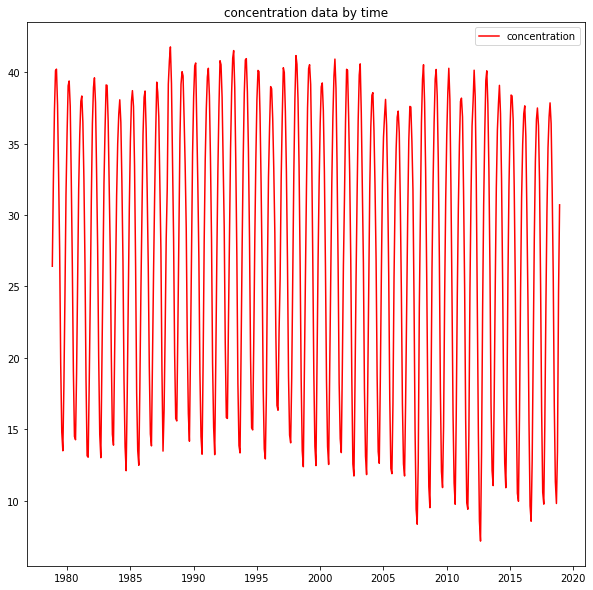

In [10]:
plt.figure(1,figsize=(10,10))

plt.plot(train_df['concentration'],label="concentration",c="red")
# plt.plot(train_df['pole'],label="pole",c="blue")
plt.title("concentration data by time")
plt.legend()
plt.plot()

Not surprisingly, concetration data shows seasonal behavior

[]

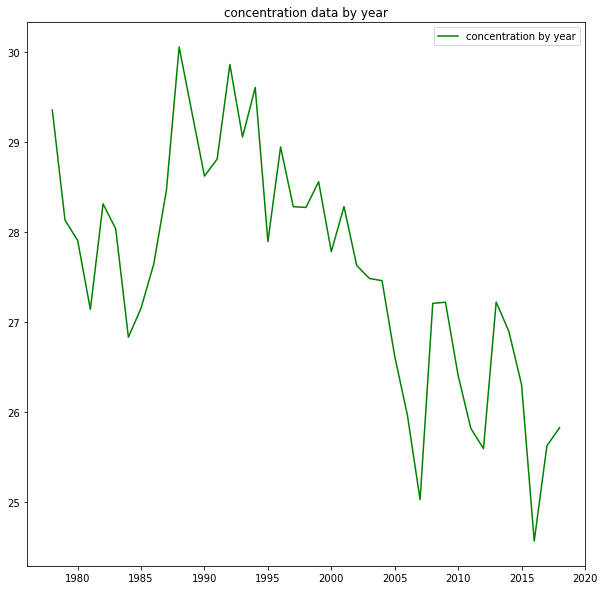

In [11]:
plt.figure(1,figsize=(10,10))

plt.plot(train_df.groupby(train_df.index.year)['concentration'].mean(),label="concentration by year",c="green")
plt.title("concentration data by year")
plt.legend()
plt.plot()

The concentration tend to decrease. 

[]

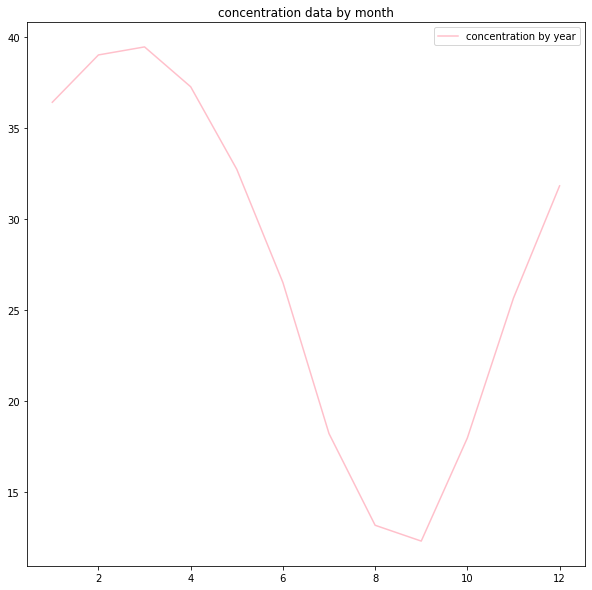

In [12]:
plt.figure(1,figsize=(10,10))

plt.plot(train_df.groupby(train_df.index.month)['concentration'].mean(),label="concentration by year",c="pink")
plt.title("concentration data by month")
plt.legend()
plt.plot()

[]

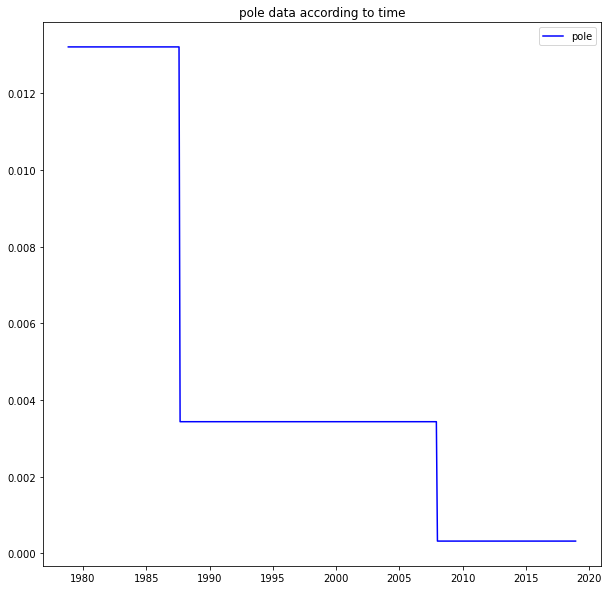

In [13]:
plt.figure(1,figsize=(10,10))

plt.plot(train_df['pole'],label="pole",c="blue")
plt.title("pole data according to time")
plt.legend()
plt.plot()

Pole data which shows the area inivisible by statelite decreases. The reason might be improvement of statelite camera or more statelites checking the north pole.

## Concentration data by year didnt show the constant decrease due to missing value.
Let's compensate this by adding 250 to the non-observable area on the pole

[]

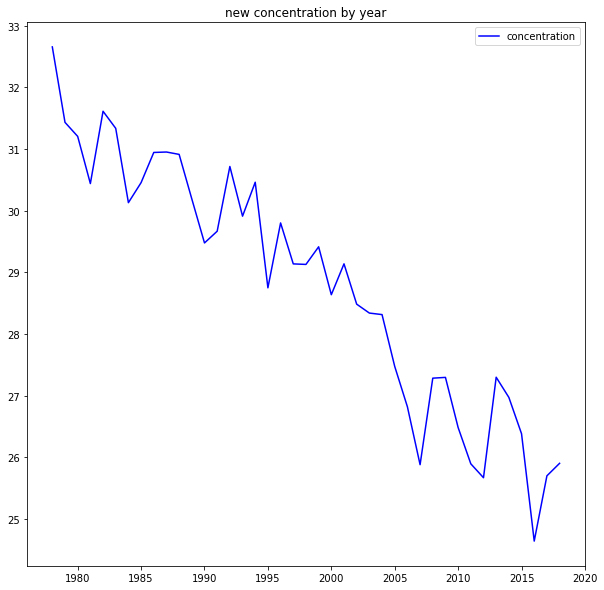

In [19]:
train_df["new_con"] = train_df['concentration'] + train_df['pole'] * 250

plt.figure(1,figsize=(10,10))
plt.plot(train_df.groupby(train_df.index.year)['new_con'].mean(),label="concentration",c="blue")
plt.title("new concentration by year")
plt.legend()
plt.plot()